In [ ]:
# if you want to use wandb for visualization you can install it in your workbook as show below
!pip install wandb -qU

In [ ]:
# Log in to your W&B account
import wandb
wandb.login(key='') # add your key here to log in to wandb if you want to use it for visualization

In [ ]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import csv
import gc
import math
from torchsummary import summary
from datetime import datetime
import random

In [ ]:
train_pre = pd.read_pickle('path_to_saved/dataport_electric_vehicle_5s.pkl')
print(train_pre)

            date  hour                                                  0
2     2014-03-01     2  [0.00041373604, 0.00041373604, 0.00041373604, ...
5     2014-03-02     1  [0.00041373604, 0.00041373604, 0.00041373604, ...
14    2014-03-04     2  [0.0003773585, 0.0003773585, 0.0003773585, 0.0...
17    2014-03-05     1  [0.0003834356, 0.0003834356, 0.0003834356, 0.0...
21    2014-03-06     1  [0.00041271152, 0.00041271152, 0.00041271152, ...
...          ...   ...                                                ...
1625  2015-04-25     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1629  2015-04-26     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1634  2015-04-27     2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1639  2015-04-28     3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1641  2015-04-29     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[2711 rows x 3 columns]


Calculate the start times of the appliances in the 6 hour windows

In [ ]:
indices = []
for index, data in train_pre.iterrows():
 # if data['hour'] == 1:
  indices.append(next((i for i, x in enumerate(data[0]) if x>0.1), None))
print(indices)
print(len(indices))

[779, 1372, 573, 965, 1059, 1345, 2421, 1237, 3663, 949, 1472, 48, 1103, 1331, 175, 21, 547, 1472, 1496, 414, 224, 289, 1283, 823, 432, 326, 1678, 70, 1717, 2633, 1362, 507, 526, 875, 336, 258, 1239, 1789, 948, 1081, 287, 1355, 1091, 614, 390, 512, 1046, 697, 1347, 170, 966, 1082, 225, 26, 425, 491, 624, 1582, 973, 377, 409, 568, 1516, 1299, 1986, 171, 3146, 48, 360, 339, 1260, 1097, 160, 2683, 2161, 1056, 3434, 3010, 90, 1268, 1017, 289, 587, 257, 1162, 48, 478, 744, 1712, 129, 242, 510, 670, 472, 1366, 356, 454, 6, 0, 694, 849, 1751, 704, 662, 1050, 755, 49, 1084, 108, 2987, 3131, 676, 82, 835, 608, 446, 7, 1453, 1061, 1310, 1940, 3398, 3115, 843, 1363, 98, 3695, 267, 171, 0, 1370, 156, 108, 433, 659, 1108, 2897, 430, 434, 71, 1173, 2756, 749, 707, 1049, 185, 117, 607, 1631, 983, 635, 797, 477, 774, 1154, 3204, 956, 1440, 588, 402, 208, 3032, 516, 330, 694, 3989, 827, 405, 656, 1770, 666, 1859, 945, 2476, 509, 28, 8, 11, 2186, 4082, 271, 359, 809, 360, 1357, 915, 453, 690, 2722, 479,

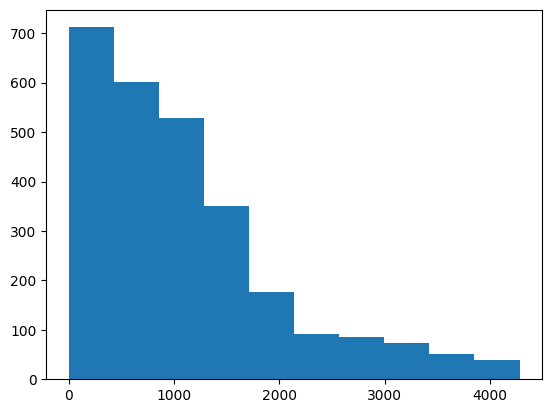

In [ ]:
plt.hist(indices)
plt.show()

Plot the real timeseries data


In [ ]:

# train_pre.columns
for index, data in train_pre.iterrows():
  print(data)
  plt.plot(data[0])
  print('index ',next((i for i, x in enumerate(data[0]) if x>0), None) )
  plt.show()
  print(np.var(data[0]))
  print(np.sum(data[0]))


This function isolates a signature of an appliance from the rest of the timeseries
 as described in the paper


In [ ]:
def isolate_samples(samples, dirty_indi, gap_size=50,min_value=0.1):
  '''
  isolate_samples function takes as input the created 6 hour windows and isolates only the signatures of the
  device, present in each window. A sliding window and convolution is used in order to perform the processing.

  :samples: the available timeseries to extract the appliance signatures
  :dirty_indi: the timeseries that are considered to include appliance signatures
  :gap_size: the size of the window used for the timeseries cleaning
  :min_value: the min value that can be considered as part of an appliance signature
  
  '''
  sizes = []
  data_trimed = []
  dirty = dirty_indi
  extra_splits = []
  for i, row in enumerate(samples):
    dirty[i] = False
    appliance = row
    appliance_ind = (appliance>min_value).argmax(axis=0)
    last_ind = appliance.shape[0] - np.flip(appliance>min_value, axis=0).argmax(axis=0) - 1
    appliance = appliance[appliance_ind:last_ind]
    #sizes.append(appliance.shape[0])

    if appliance.shape[0] > gap_size:
      a = np.convolve(appliance, np.ones(gap_size), 'valid') / gap_size
      split = np.argmax(a==0)

      if split:
        dirty[i] = True
        b = appliance[split:]
        appliance = appliance[:split]

        appliance_ind = (b!=0).argmax(axis=0)
        last_ind = b.shape[0] - np.flip(b!=0, axis=0).argmax(axis=0) - 1
        b = b[appliance_ind:last_ind]

        appliance_ind = (appliance!=0).argmax(axis=0)
        last_ind = appliance.shape[0] - np.flip(appliance!=0, axis=0).argmax(axis=0) - 1
        appliance = appliance[appliance_ind:last_ind]

        if b.shape[0] > 50:
          extra_splits.append(b)
          sizes.append(b.shape[0])
      if appliance.shape[0] > 50:
        data_trimed.append(appliance)
        sizes.append(appliance.shape[0])

  if len(extra_splits) > 0:
    dirty = np.hstack([dirty, np.ones(len(extra_splits),dtype=np.bool8)])
    data_trimed.extend(extra_splits)

  return data_trimed, dirty, sizes

2711
4581
[51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 6

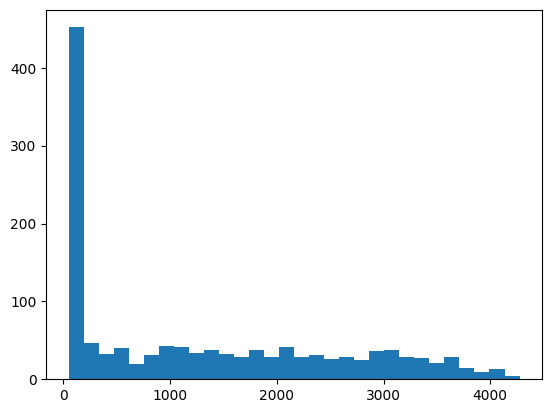

       0         1         2         3         4         5         6     \
0  0.207925  0.902641  0.902641  0.910943  0.906792  0.906792  0.909811   
1  0.922929  0.905675  0.904525  0.904525  0.897623  0.897623  0.897623   
2  0.944284  0.944284  0.982666  0.965745  0.971936  0.970285  0.970285   
3  0.973982  0.971045  0.963911  0.963911  0.973143  0.954679  0.954679   
4  0.977686  0.961570  0.961570  0.959917  0.959917  0.955372  0.956612   

       7         8         9     ...  1490  1491  1492  1493  1494  1495  \
0  0.910566  0.906038  0.906038  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.897623  0.894939  0.896472  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2  0.963681  0.964920  0.979364  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3  0.966429  0.960134  0.956777  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.968182  0.968182  0.957851  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   1496  1497  1498  1499  
0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0  
2   0.0 

In [ ]:

window_size = 1500  # 4319 # 1500 #7500
print(len(train_pre))
# create a numpy array to be used for cleaning the timeseries
dirt = np.ones(len(train_pre),dtype=np.bool8)
data_train = [row[0] for index, row in train_pre.iterrows()]

# call the isolation function recursively to seperate the signatures
i = 0
while np.max(dirt) > 0 and i < 10:
  data_train, dirt, sizes = isolate_samples(data_train, dirt)
  i = i + 1

print(len(dirt))

sizes.sort()
print(sizes)
print(type(data_train))
print(len(data_train))
plt.hist(sizes,30)
plt.show()

# create the final pandas dataframe with the training data for the appliance
final  = []
for i in data_train:
  if i.shape[0] < window_size:
    i = np.pad(i, (0,window_size-i.shape[0]), 'constant', constant_values=(0,0))
    if np.sum(i) > 1:
      final.append(i)
final_data = pd.DataFrame(final)

print(final_data.head())
print(len(final_data))

In [ ]:
# save again in a pickle file the cleaned dataset for the appliance
final_data.to_pickle("path_to_saved/dataport_electric_vehicle_5s_clean.pkl")